In [1]:
import os
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
from ResoFit.calibration import Calibration
from ResoFit.fitresonance import FitResonance
from ResoFit.experiment import Experiment
from ResoFit.simulation import Simulation
from ImagingReso.resonance import Resonance
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as ss
import pprint
from ResoFit._utilities import get_foil_density_gcm3
from ResoFit._utilities import Layer
import peakutils as pku

In [2]:
%matplotlib notebook

In [26]:
# Global parameters
energy_min = 1
energy_max = 1000
energy_step = 0.01
# Input sample name or names as str, case sensitive
layers = Layer()
# layers.add_layer(layer='Ag', thickness_mm=0.025)
# layers.add_layer(layer='Au', thickness_mm=0.01)
# layers.add_layer(layer='Cd', thickness_mm=0.5)
# layers.add_layer(layer='Co', thickness_mm=0.025)
# layers.add_layer(layer='Hf', thickness_mm=0.025)
# layers.add_layer(layer='In', thickness_mm=0.05)
# layers.add_layer(layer='W', thickness_mm=0.05)
layers.add_layer(layer='U', thickness_mm=0.01)
# layers.add_layer(layer='I', thickness_mm=0.01)

# density = get_foil_density_gcm3(length_mm=25, width_mm=25, thickness_mm=0.025, mass_g=0.14)

simu = Simulation(energy_min=energy_min, energy_max=energy_max, energy_step=energy_step)
simu.add_Layer(layer=layers)

In [24]:
simu.layer_list

['Ag', 'Au', 'Cd', 'Co', 'Hf', 'In', 'W']

<IPython.core.display.Javascript object>


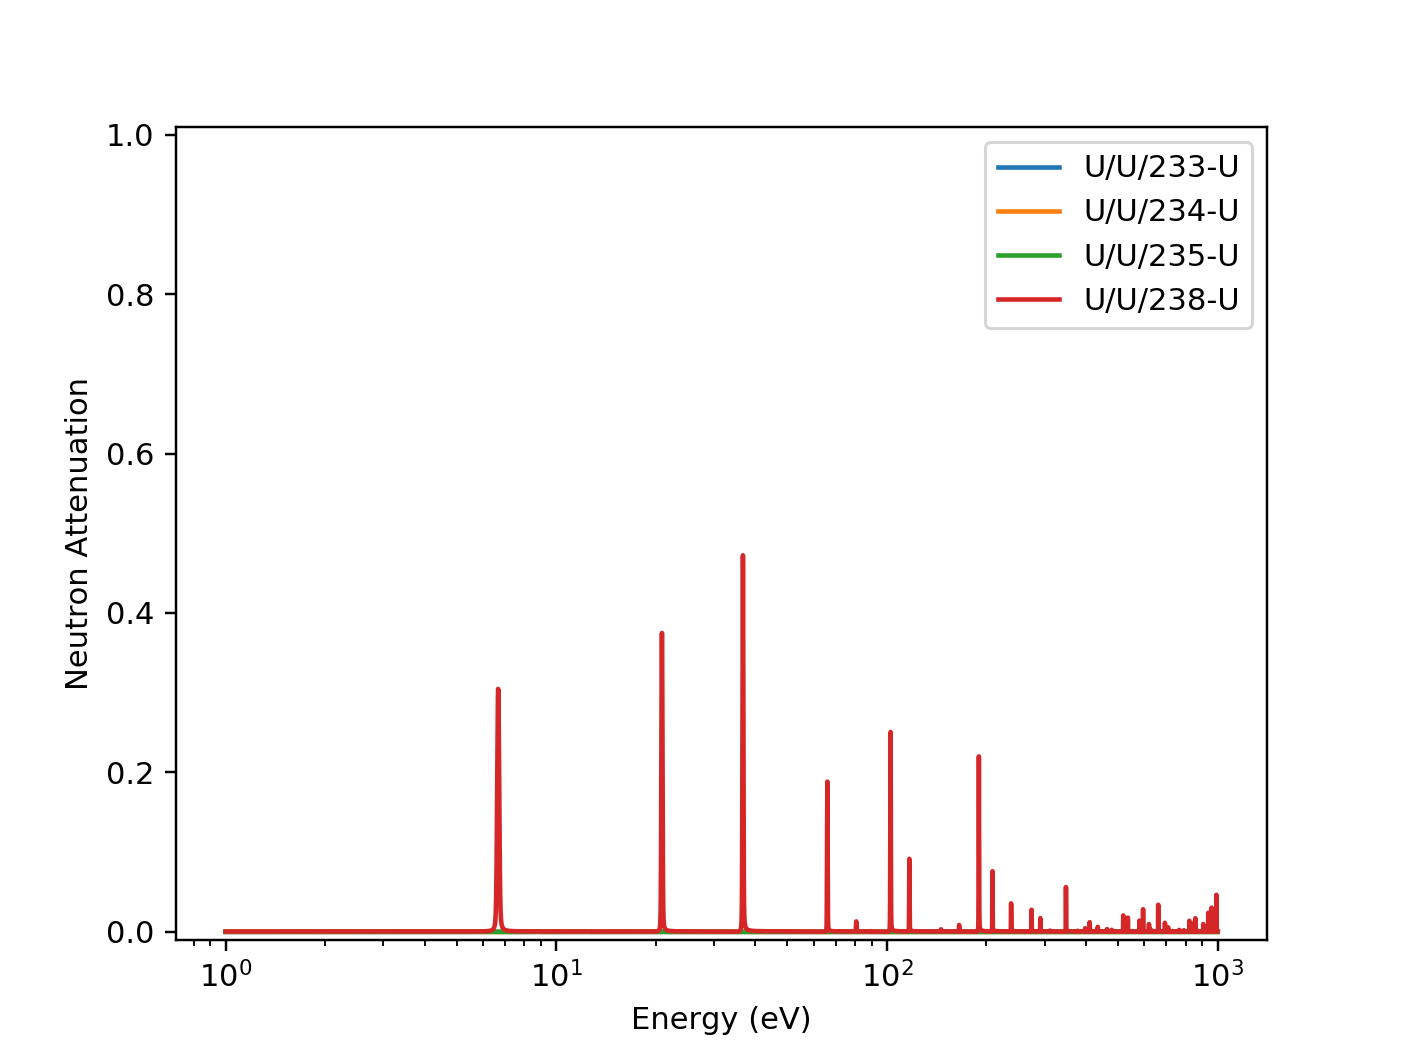

In [38]:
simu.plot(all_isotopes=True, mixed=False, logx=True,
#           logy=True,
#           items_to_plot=['U238', 'U235']
#            y_type='sigma_raw',
         )

In [42]:
pprint.pprint(simu.o_reso.stack_sigma)

{'Ag': {'Ag': {'107-Ag': {'energy_eV': array([   1.  ,    1.01,    1.02, ...,  999.98,  999.99, 1000.  ]),
                          'sigma_b': array([6.39215496, 6.37309551, 6.35518929, ..., 2.73491183, 2.73483833,
       2.73476483]),
                          'sigma_b_raw': array([12.3307837 , 12.29401708, 12.25947509, ...,  5.27578046,
        5.27563867,  5.27549689])},
               '109-Ag': {'energy_eV': array([   1.  ,    1.01,    1.02, ...,  999.98,  999.99, 1000.  ]),
                          'sigma_b': array([11.32874099, 11.32392034, 11.31909968, ...,  3.33540078,
        3.33405441,  3.33270804]),
                          'sigma_b_raw': array([23.52264486, 23.5126354 , 23.50262595, ...,  6.92552228,
        6.92272671,  6.91993114])},
               '110-Ag': {'energy_eV': array([   1.  ,    1.01,    1.02, ...,  999.98,  999.99, 1000.  ]),
                          'sigma_b': array([0., 0., 0., ..., 0., 0., 0.]),
                          'sigma_b_raw': array([11.49874

<IPython.core.display.Javascript object>


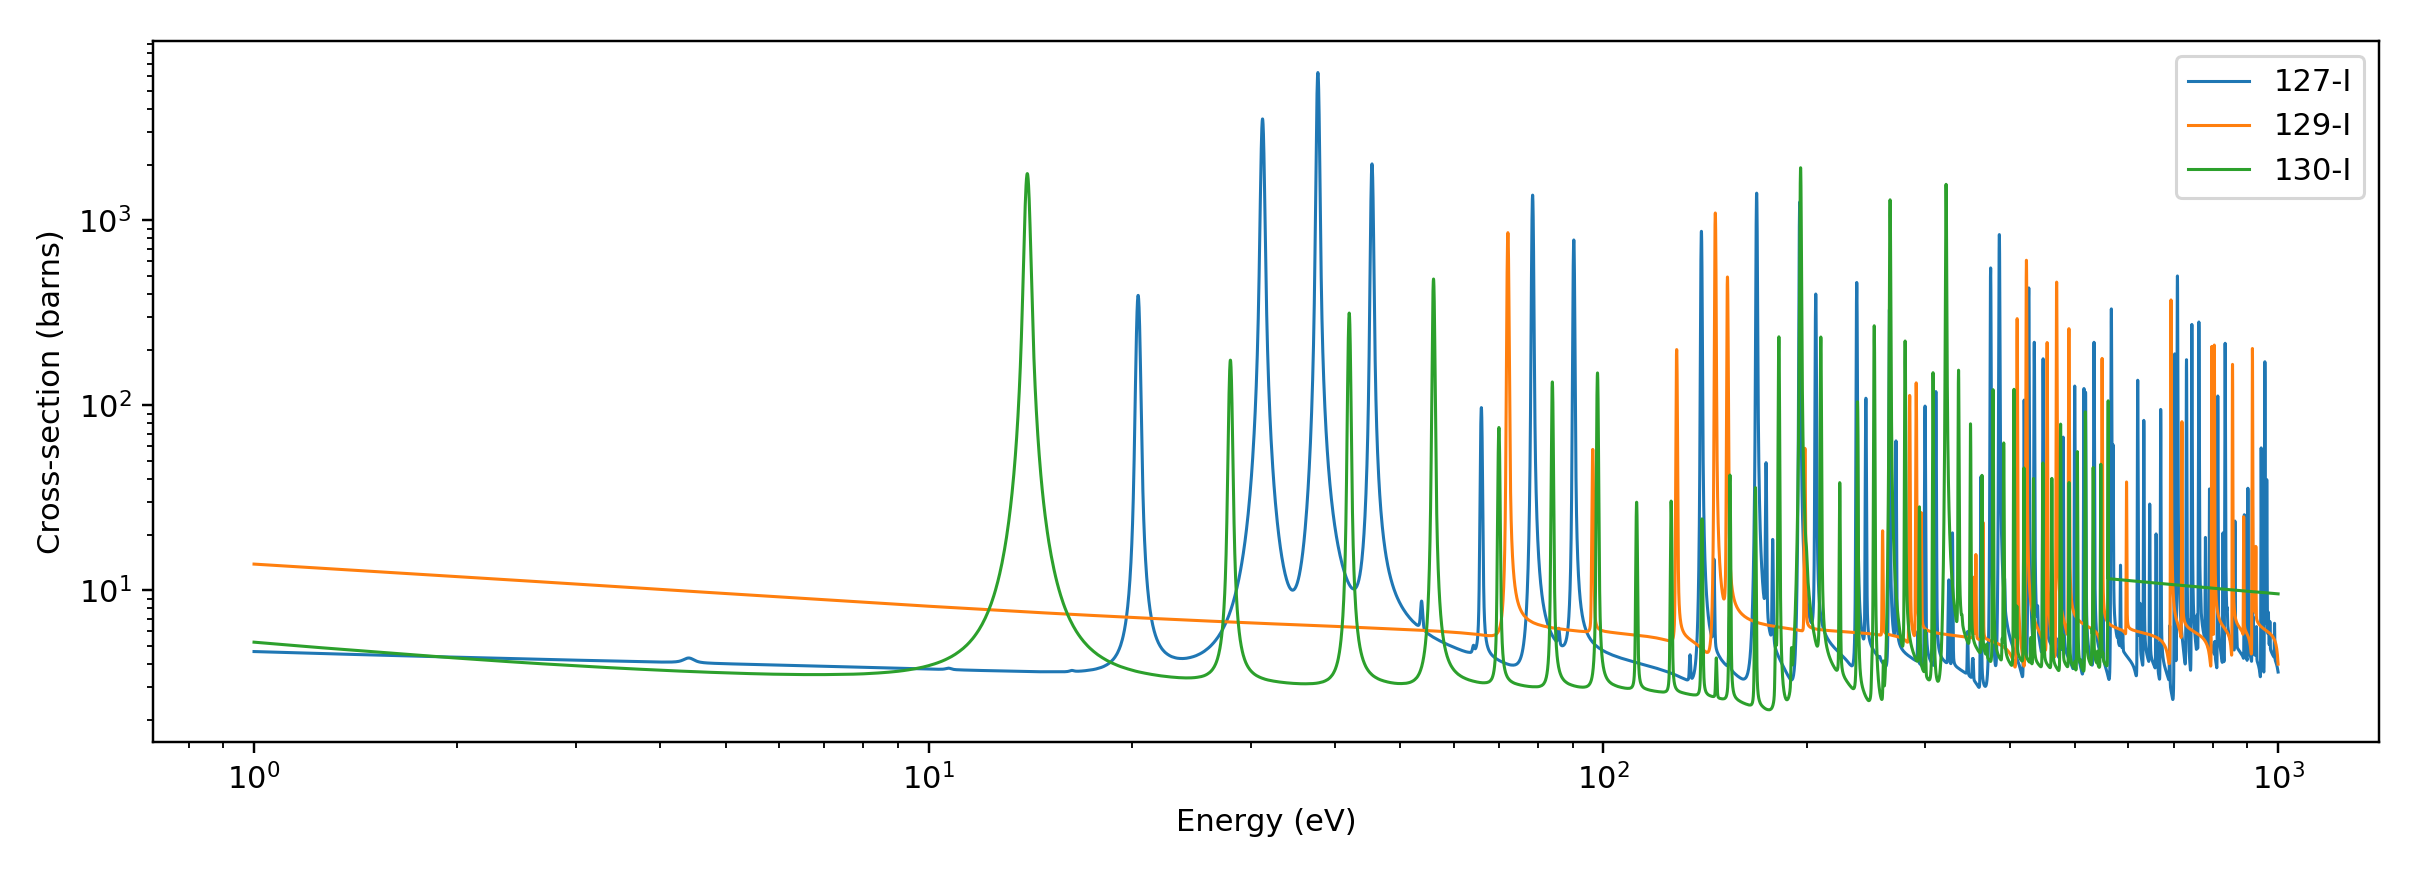

'y_axis='sigma'' is selected. Auto force 'mixed=False', 'all_layers=False'


In [44]:
item_list = [
#     '107-Ag',
#     '109-Ag',
#     '235-U',
#     '238-U',
    '127-I',
    '129-I',
    '130-I',
            ]
fig, ax0 = plt.subplots(figsize=(11,4))
ax = simu.plot(y_type='sigma_raw',
               mixed= False,
               all_elements=False,
               logx=True, logy=True,
               fmt='-', ms=1, lw=1,
               items_to_plot=item_list,
              ax_mpl=ax0)
_legend = ax.legend()
for _i, name in enumerate(item_list):
    _legend.get_texts()[_i].set_text(name)
plt.tight_layout()
fig.savefig(dpi=300, fname='Ag')

In [5]:
folder = 'data/IPTS_13639/reso_data_13639'
data_file = layer_1 + '.csv'
spectra_file = 'spectra.csv'
image_start = 500  # Can be omitted or =None
image_end = 1600  # Can be omitted or =None
norm_to_file = 'Ag.csv'
baseline = True
each_step = False
before = False
table = True
fit_vary = 'none'

repeat = 1
source_to_detector_m = 16.293278721983177  # 16#16.445359069030175#16.447496101100739
offset_us = -12112.494119089204  # 0#2.7120797253959119#2.7355447625559037

In [ ]:
# Calibrate the peak positions
calibration = Calibration(data_file=data_file,
                          spectra_file=spectra_file,
                          layer=layer,
                          energy_min=energy_min,
                          energy_max=energy_max,
                          energy_step=energy_step,
                          repeat=repeat,
                          folder=folder,
                          baseline=baseline)

calibration.norm_to(norm_to_file)
calibration.slice(slice_start=image_start, slice_end=image_end)

calibrate_result = calibration.calibrate(source_to_detector_m=source_to_detector_m,
                                         offset_us=offset_us,
                                         vary='all',
                                         each_step=each_step)
calibration.index_peak(thres=0.5, min_dist=50)
# calibration.analyze_peak()
pprint.pprint(calibration.experiment.o_peak.peak_map_indexed)
# peak_df = calibration.peak_df_scaled

calibration.plot(before=before, table=table, peak_id='all')

In [3]:
# Fit the peak height
fit = FitResonance(folder=folder,
                   spectra_file=spectra_file,
                   data_file=data_file,
                   repeat=repeat,
                   energy_min=energy_min,
                   energy_max=energy_max,
                   energy_step=energy_step,
                   calibrated_offset_us=calibration.calibrated_offset_us,
                   calibrated_source_to_detector_m=calibration.calibrated_source_to_detector_m,
                   norm_to_file=norm_to_file,
                   slice_start=image_start,
                   slice_end=image_end,
                   baseline=baseline)
fit_result = fit.fit(layer, vary=fit_vary, each_step=each_step)
fit.molar_conc()
# fit.fit_iso(layer=layer_1)
fit.index_peak(thres=0.5, min_dist=50)
fit.plot(before=before, table=table, peak_id='all')

In [6]:
# foil_list = ['Ag', 'Co', 'Hf', 'W', 'In', 'Cd', 'Au', 'all']
# foil_list = ['Ag', 'Co', 'Hf', 'W', 'In', 'Cd', 'Au']
foil_list = ['Co', 'Cd', 'W', 'In', 'Hf', 'Ag', 'Au']

data_file_list = [x + '.csv' for x in foil_list]
folder = 'data/IPTS_13639/reso_data_13639'
spectra_file = 'spectra.csv'
exps = {}
for each_data in data_file_list:
    _ele_name = each_data.split('.')[0]
    exps[_ele_name] = Experiment(spectra_file=spectra_file, data_file=each_data, folder=folder)
    exps[_ele_name].slice(start=294, end=2720)
#     exps[_ele_name].slice(start=294, end=2570)
    if _ele_name == 'Co':
        exps[_ele_name].norm_to('Ag.csv')
    elif _ele_name == 'Cd':
        exps[_ele_name].norm_to('In.csv')
    elif _ele_name == 'W':
        exps[_ele_name].norm_to('Hf.csv')
    else:
        exps[_ele_name].norm_to('ob_all.csv')

In [7]:
exps

{'Co': <ResoFit.experiment.Experiment at 0x1a0d81cf28>,
 'Cd': <ResoFit.experiment.Experiment at 0x1c1fa49f28>,
 'W': <ResoFit.experiment.Experiment at 0x1c17d0bfd0>,
 'In': <ResoFit.experiment.Experiment at 0x1c17d0c0f0>,
 'Hf': <ResoFit.experiment.Experiment at 0x1c17d02f28>,
 'Ag': <ResoFit.experiment.Experiment at 0x1c17cfd0f0>,
 'Au': <ResoFit.experiment.Experiment at 0x1c17cf80f0>}

In [8]:
image_start = 500  # Can be omitted or =None
image_end = 1600  # Can be omitted or =None
# norm_to_file = 'ob_1.csv'  #'Ag.csv'
# norm_to_file = 'Ag.csv'
norm_to_file = None

repeat = 1
source_to_detector_m = 16.123278721983177  # 16#16.445359069030175#16.447496101100739
offset_us = -12112.494119089204  # 0#2.7120797253959119#2.7355447625559037

<IPython.core.display.Javascript object>


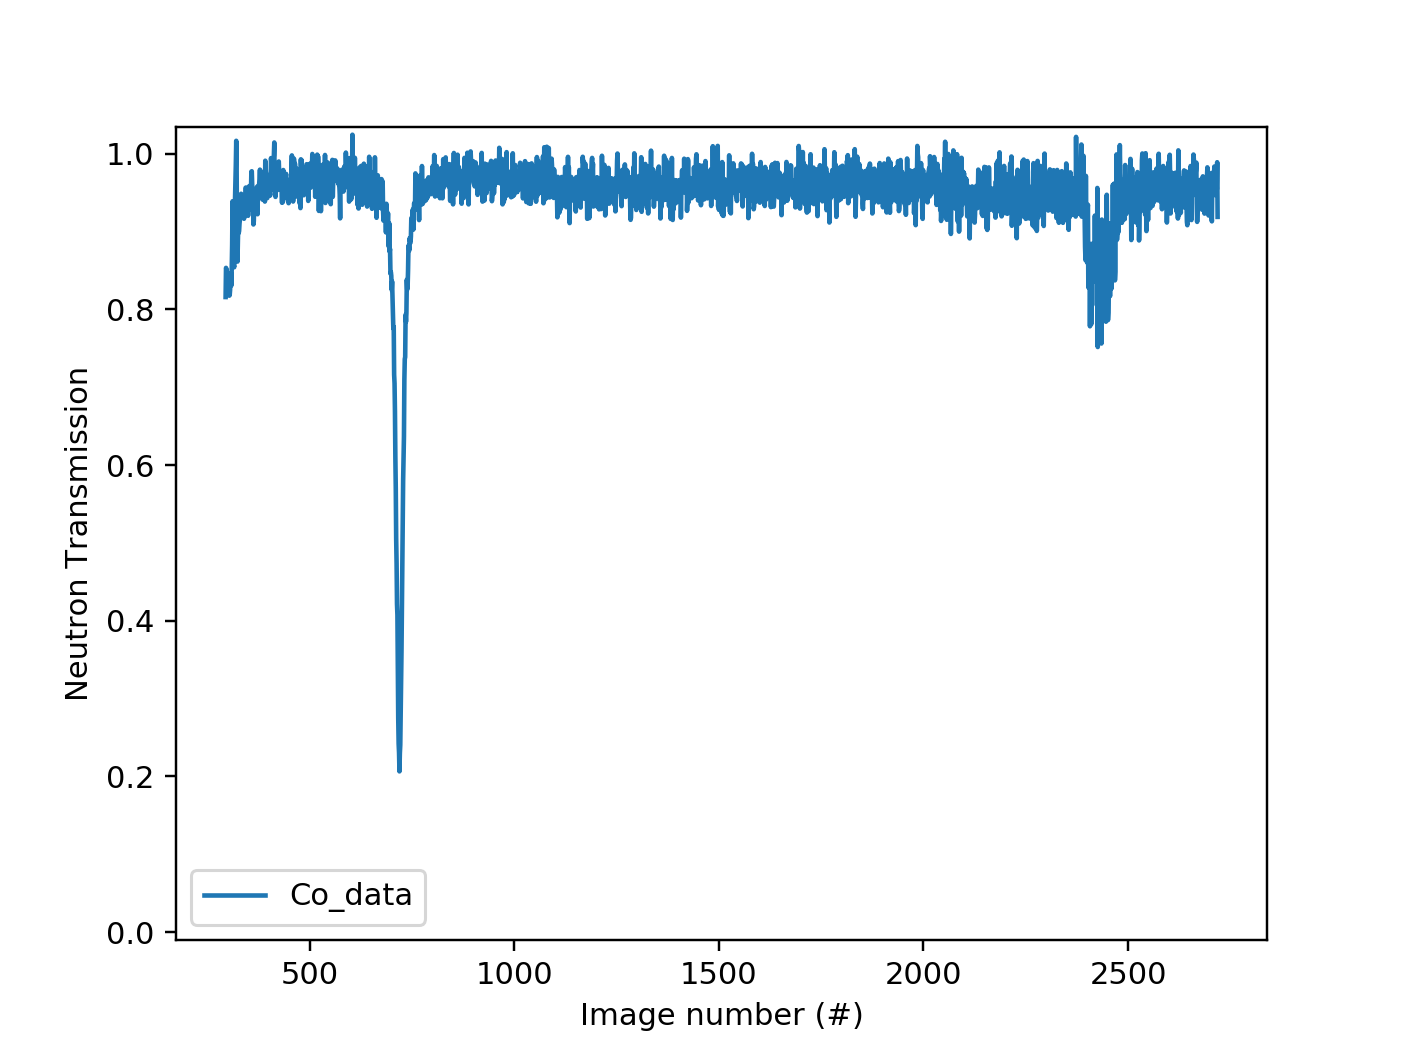

In [9]:
exps['Co'].plot(x_type='number', y_type='transmission',
                source_to_detector_m=source_to_detector_m, offset_us=offset_us,
                logx=False, baseline=True, deg=7, fmt='-')

<IPython.core.display.Javascript object>


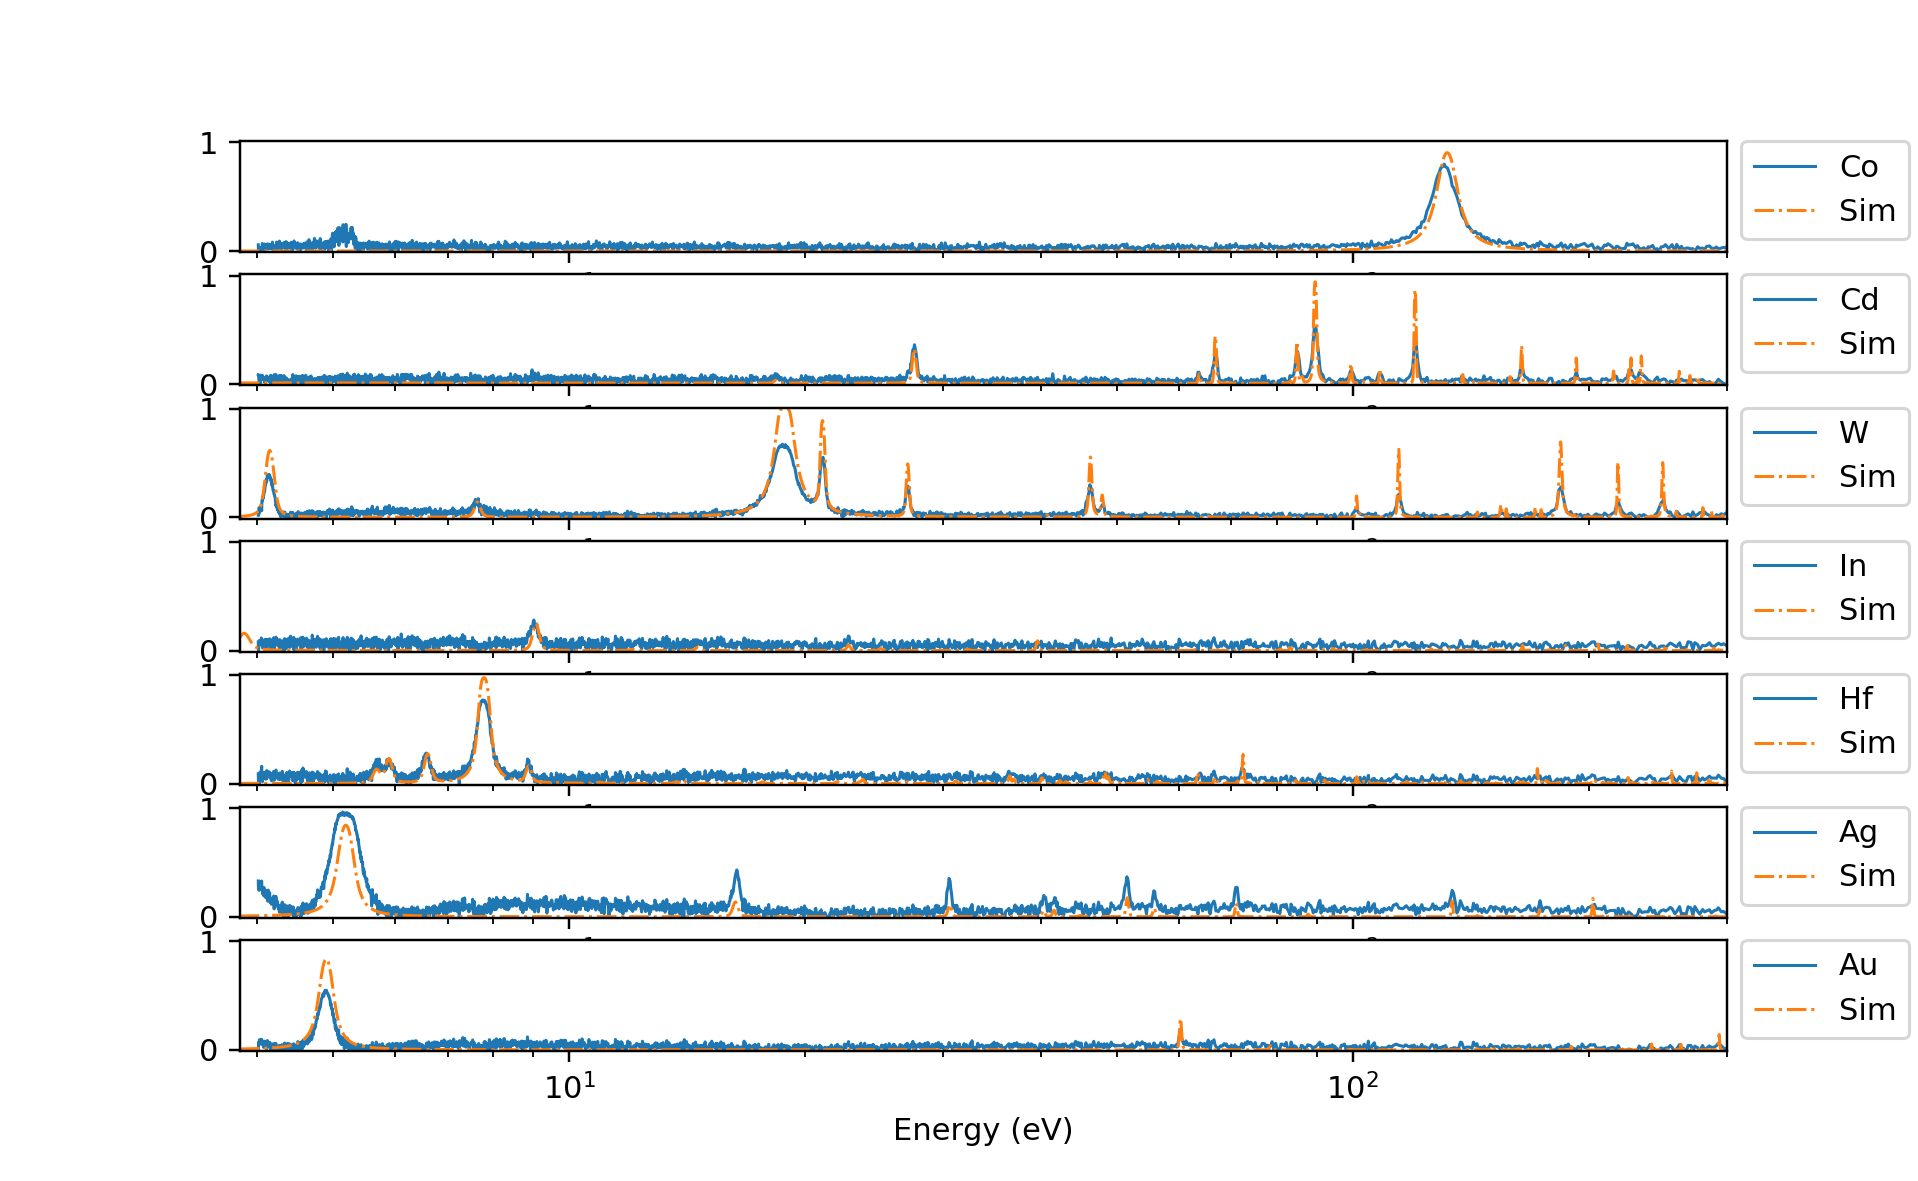

In [40]:
fg0, ax0 = plt.subplots(len(foil_list),1,figsize=(9,8))
for i, _ele in enumerate(foil_list):

    exps[_ele].plot(ax_mpl=ax0[i], x_type='energy', y_type='attenuation',
                    source_to_detector_m=source_to_detector_m, offset_us=offset_us,
                    logx=True, baseline=True, deg=6, fmt='-', lw=1)
    simu.plot(ax_mpl=ax0[i], x_type='energy', y_type='attenuation',
                source_to_detector_m=source_to_detector_m, offset_us=offset_us, logx=True,
                mixed=False, all_layers=False, all_elements=False, items_to_plot=[_ele],
             fmt='-.', lw=1, alpha=1)    
    ax0[i].set_ylabel('')
#     ax0[i].set_ylim(top=1.25, bottom=-0.25)
    ax0[i].set_xlim(left=3.8, right=300)
    _legend = ax0[i].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    _legend.get_texts()[0].set_text(_ele)
    _legend.get_texts()[1].set_text('Sim')


# ax0.set(ylabel='Neutron attenuation')

<IPython.core.display.Javascript object>


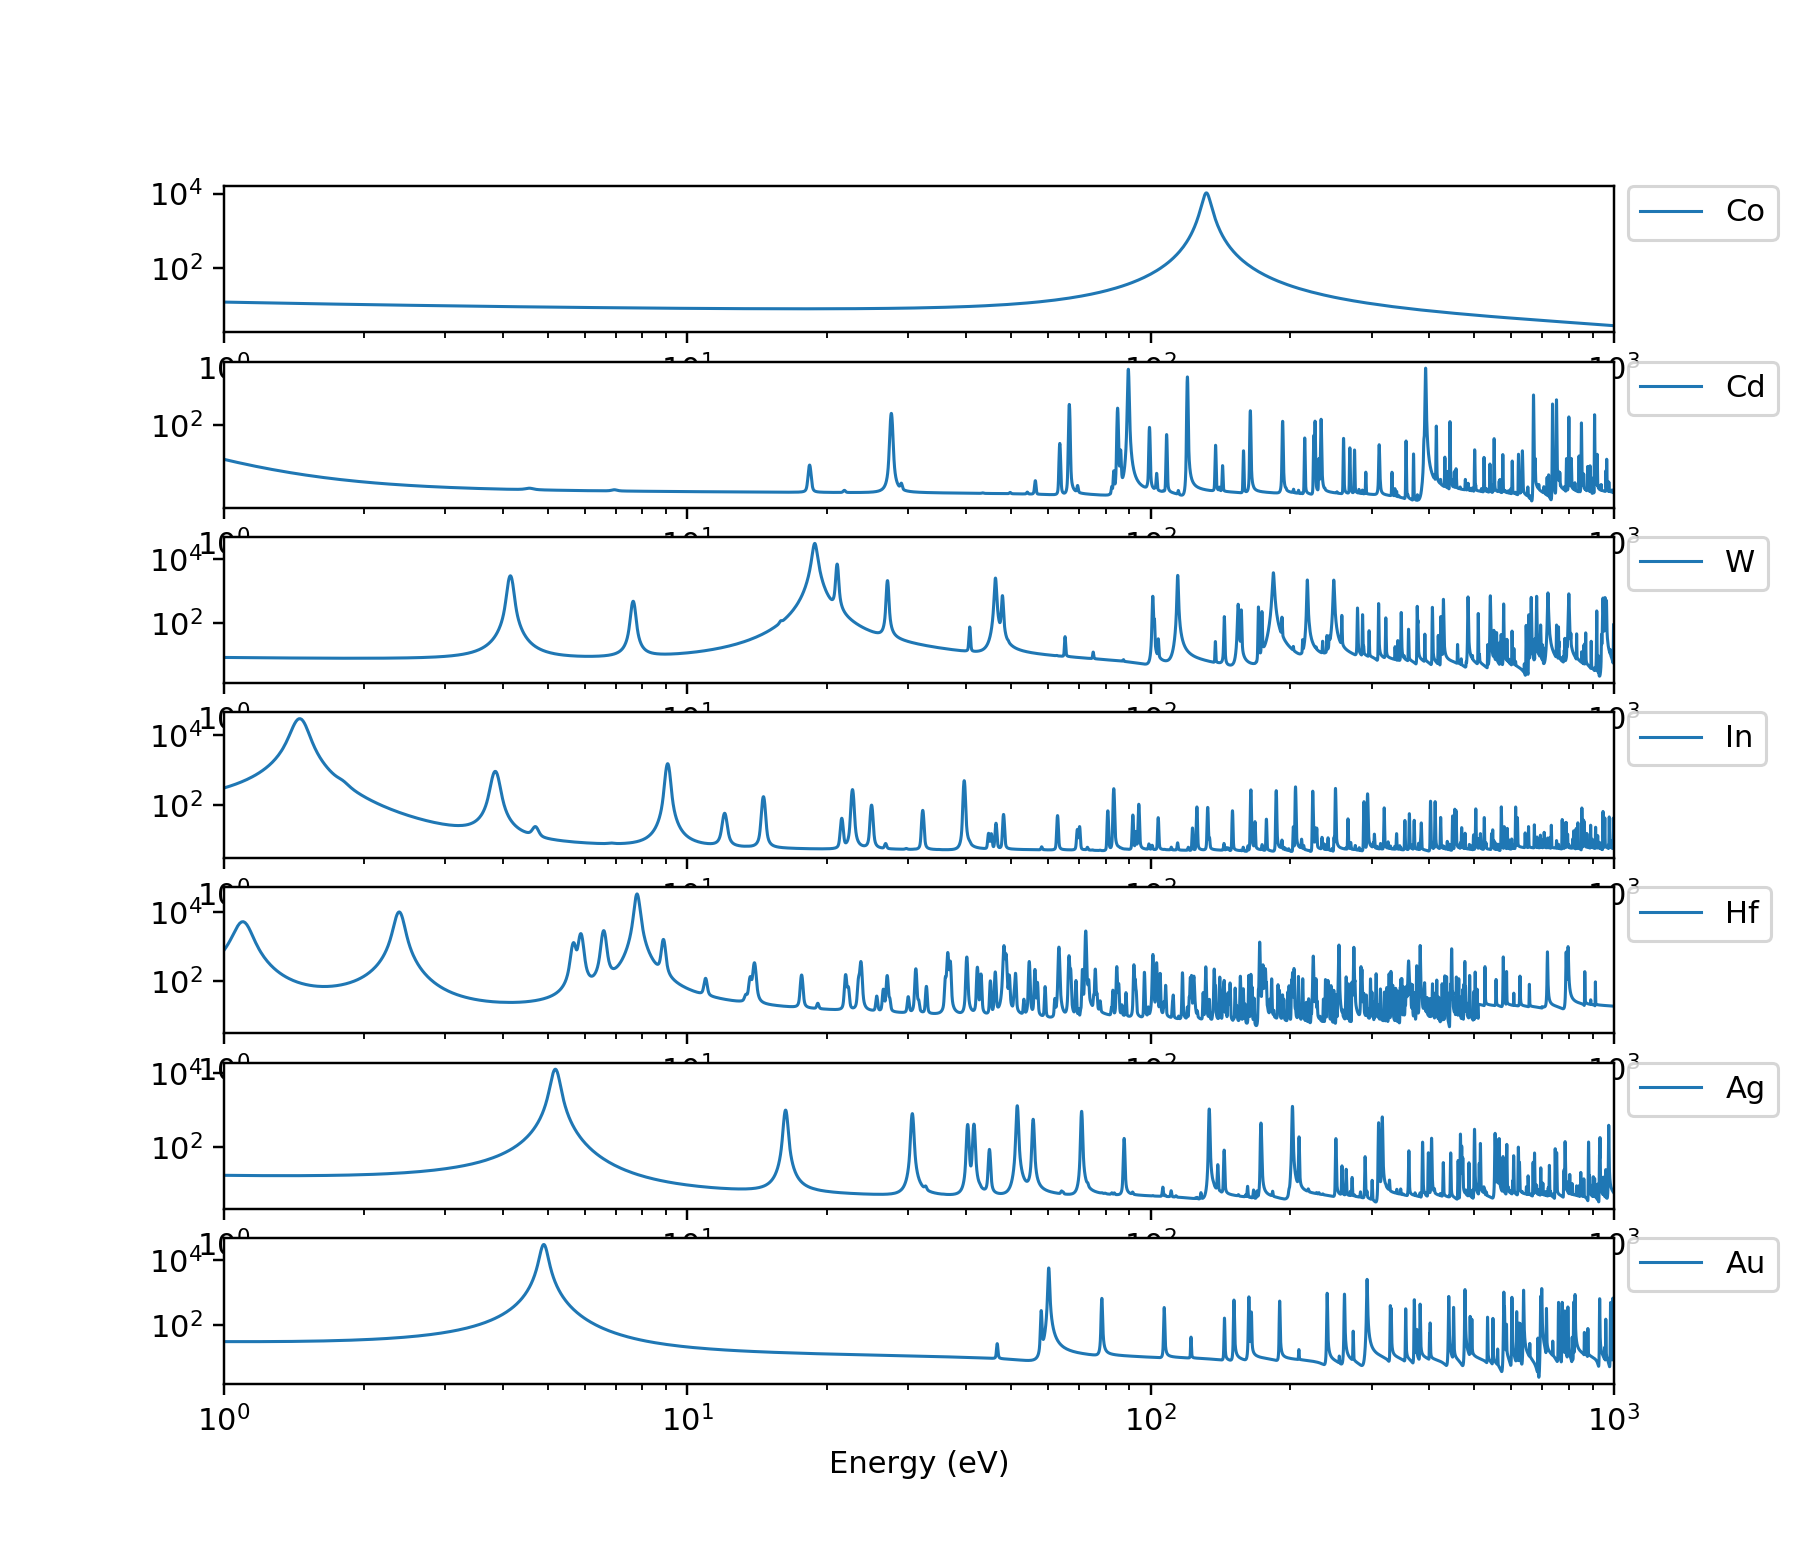

'y_axis='sigma'' is selected. Auto force 'mixed=False', 'all_layers=False'
'y_axis='sigma'' is selected. Auto force 'mixed=False', 'all_layers=False'
'y_axis='sigma'' is selected. Auto force 'mixed=False', 'all_layers=False'
'y_axis='sigma'' is selected. Auto force 'mixed=False', 'all_layers=False'
'y_axis='sigma'' is selected. Auto force 'mixed=False', 'all_layers=False'
'y_axis='sigma'' is selected. Auto force 'mixed=False', 'all_layers=False'
'y_axis='sigma'' is selected. Auto force 'mixed=False', 'all_layers=False'


In [18]:
fg0, ax0 = plt.subplots(len(foil_list),1,figsize=(9,8))
for i, _ele in enumerate(foil_list):

#     exps[_ele].plot(ax_mpl=ax0[i], x_type='energy', y_type='attenuation',
#                     source_to_detector_m=source_to_detector_m, offset_us=offset_us,
#                     logx=True, baseline=True, deg=6, fmt='-', lw=1)
    simu.plot(ax_mpl=ax0[i], x_type='energy', y_type='sigma',
#                 source_to_detector_m=source_to_detector_m, offset_us=offset_us,
              logx=True, logy=True,
              mixed=False, all_layers=False, all_elements=False, items_to_plot=[_ele],
             fmt='-', lw=1, alpha=1)    
    ax0[i].set_ylabel('')
#     ax0[i].set_ylim(top=1.25, bottom=-0.25)
    ax0[i].set_xlim(left=1, right=1000)
    _legend = ax0[i].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    _legend.get_texts()[0].set_text(_ele)
#     _legend.get_texts()[1].set_text('Sim')


# ax0.set(ylabel='Neutron attenuation')

<IPython.core.display.Javascript object>


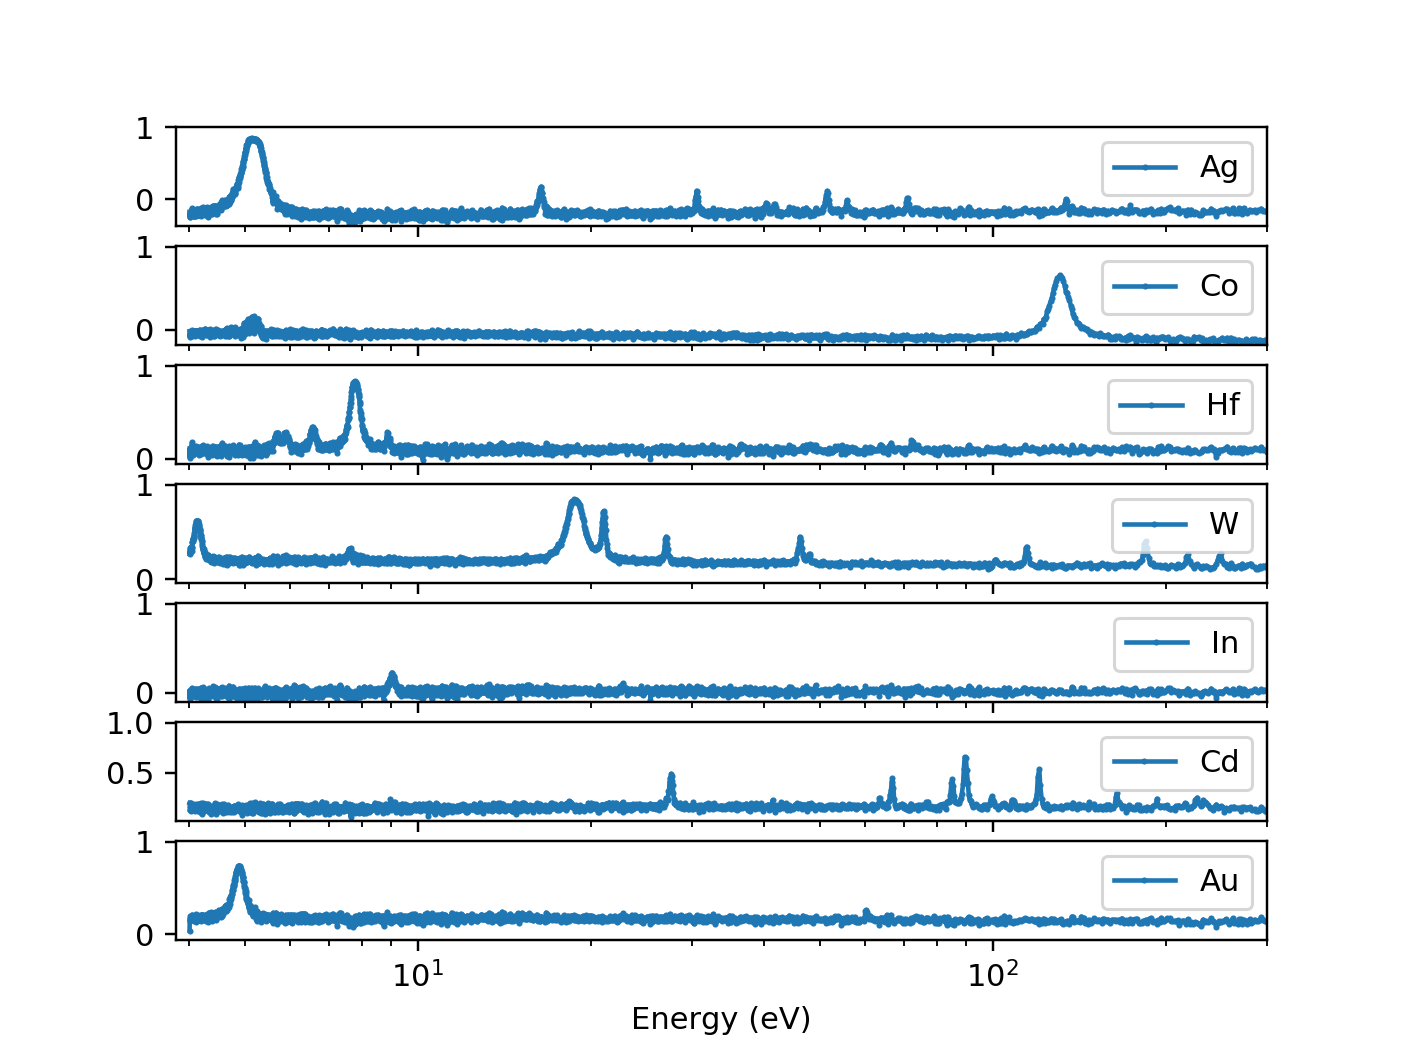

In [10]:
fg0, ax0 = plt.subplots(len(foil_list),1)
for i, _ele in enumerate(foil_list):
    exps[_ele].plot_raw(ax_mpl=ax0[i], x_type='energy', y_type='attenuation',
                        source_to_detector_m=source_to_detector_m, offset_us=offset_us,
                        logx=True, baseline=False, deg=7)
    o_reso.plot()
    
    ax0[i].set_ylabel('')
#     ax0[i].set_ylim(top=1.25, bottom=-0.25)
    ax0[i].set_xlim(left=3.8, right=300)
    ax0[i].legend(loc=1)
# ax0.set(ylabel='Neutron attenuation')

<IPython.core.display.Javascript object>


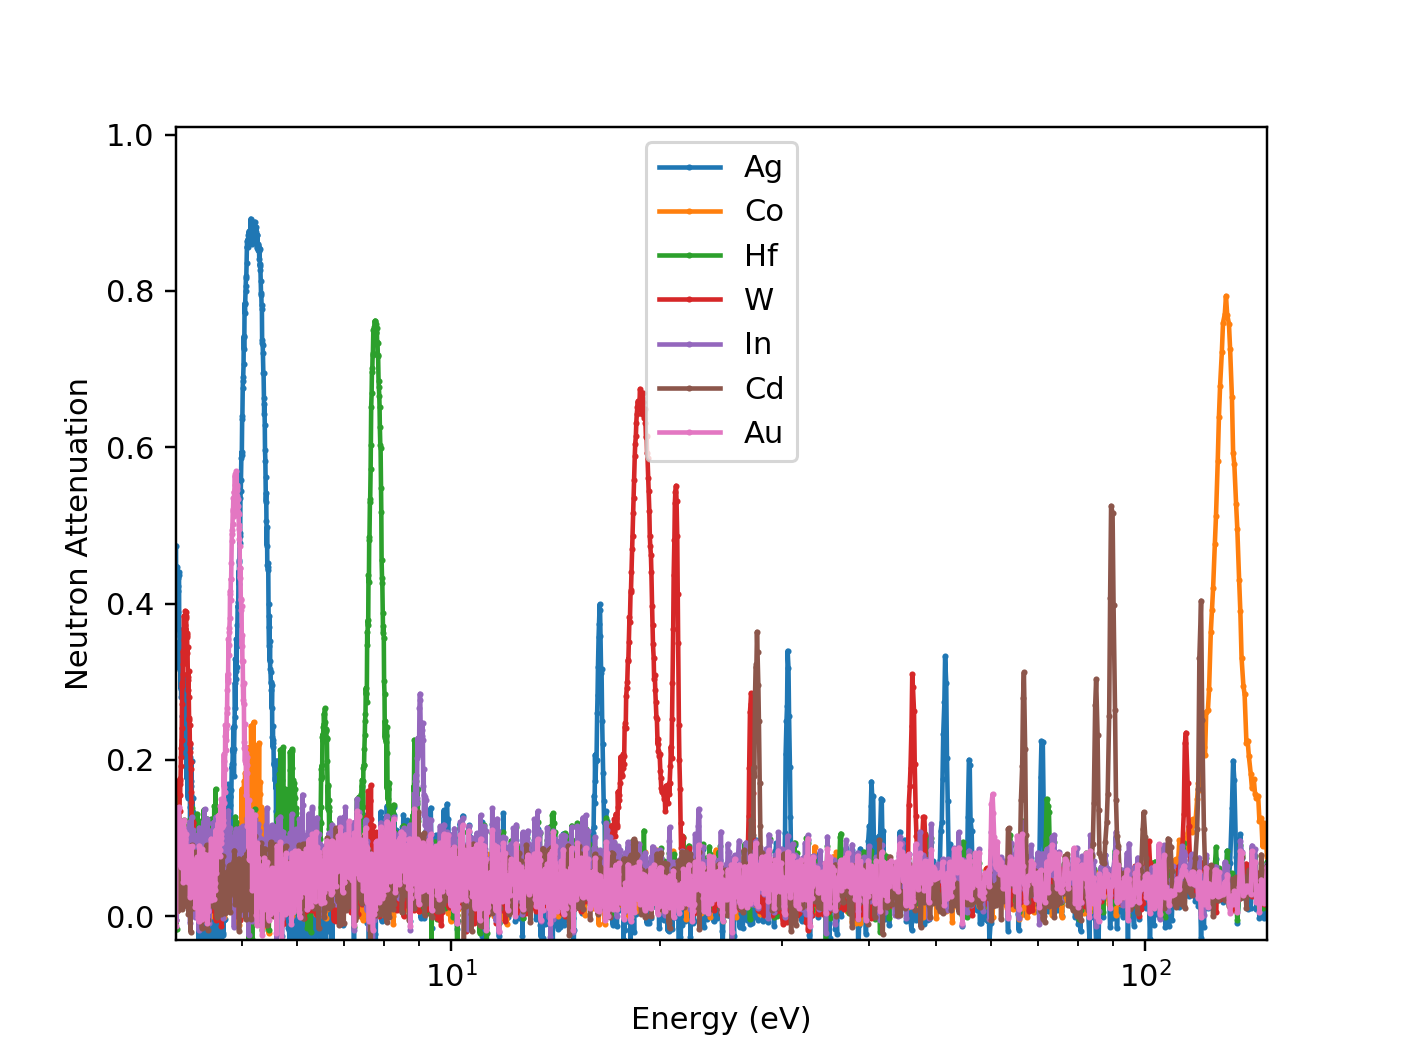

/Users/y9z/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning:

Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.



In [11]:
fg1, ax1 = plt.subplots()
for i, _ele in enumerate(foil_list):
    ax1 = exps[_ele].plot_raw(ax_mpl=ax1, x_type='energy', y_type='attenuation',
                        source_to_detector_m=source_to_detector_m, offset_us=offset_us,
                        logx=True, baseline=True, deg=7)
#     ax0[i].set_ylabel('')
#     ax0[i].set_ylim(top=1.25, bottom=-0.25)
#     ax0[i].set_xlim(left=4, right=300)
#     ax0[i].legend(loc=1)
# ax0.set(ylabel='Neutron attenuation')

<IPython.core.display.Javascript object>


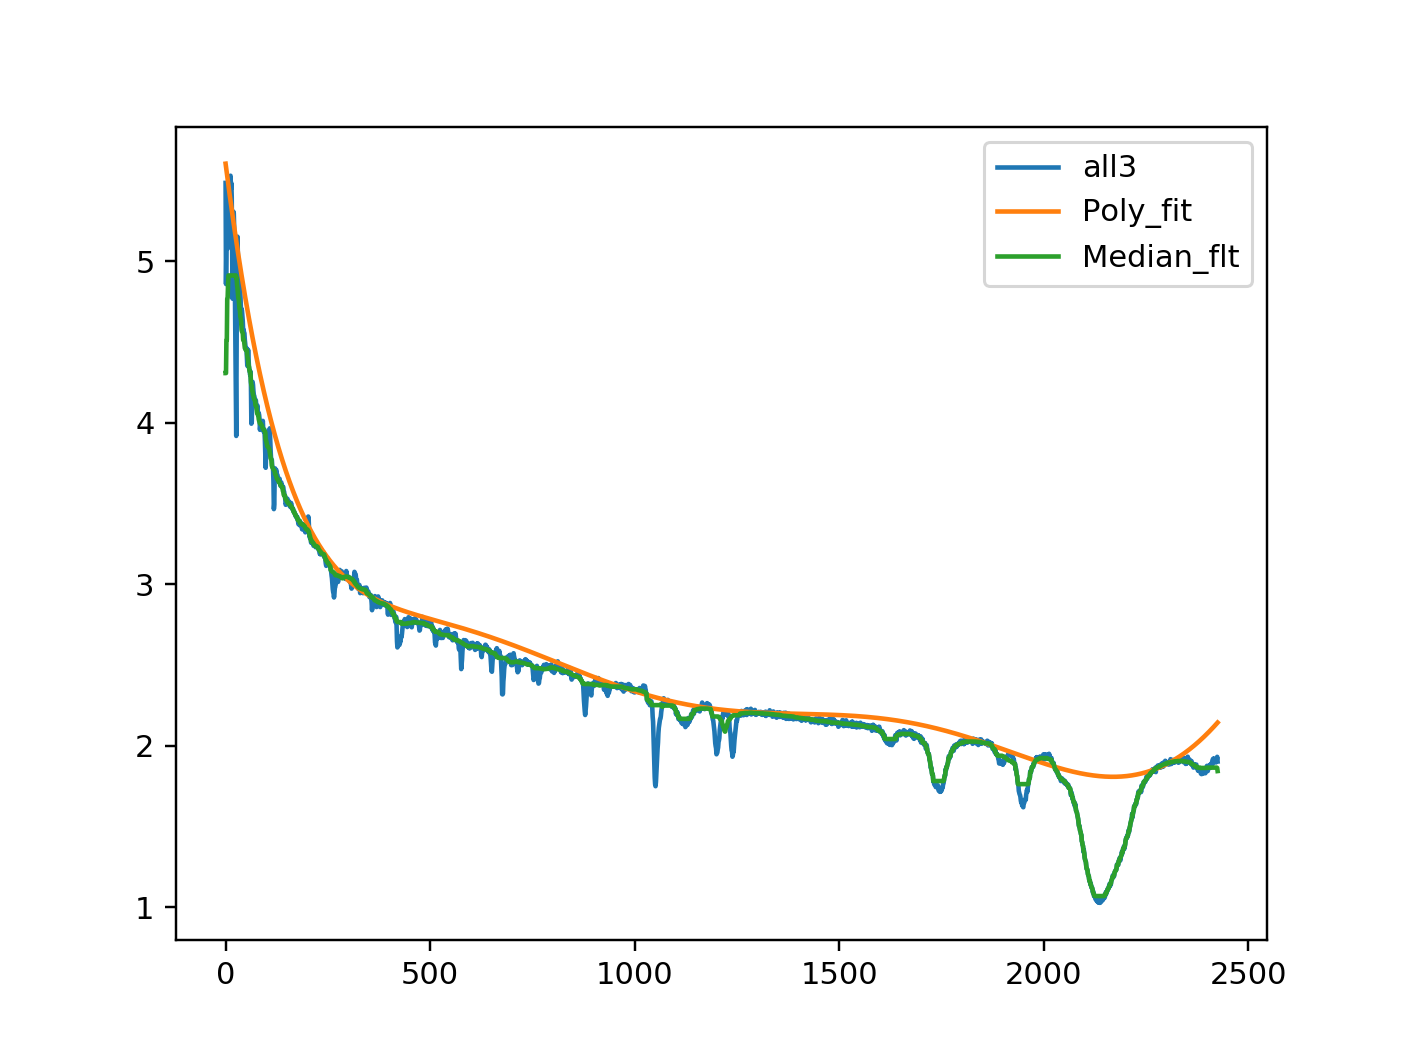

In [22]:
# arr_ag = np.array(exps['all3'].data[0])
bkg_ag = pku.envelope(y=arr_ag, deg=7, max_it=None, tol=None)
flt_ag = ss.medfilt(arr_ag, 51)
fig1, ax1 = plt.subplots()
ax1.plot(arr_ag, label='all3')
ax1.plot(bkg_ag, label='Poly_fit')
ax1.plot(flt_ag, label='Median_flt')
ax1.legend()

<IPython.core.display.Javascript object>


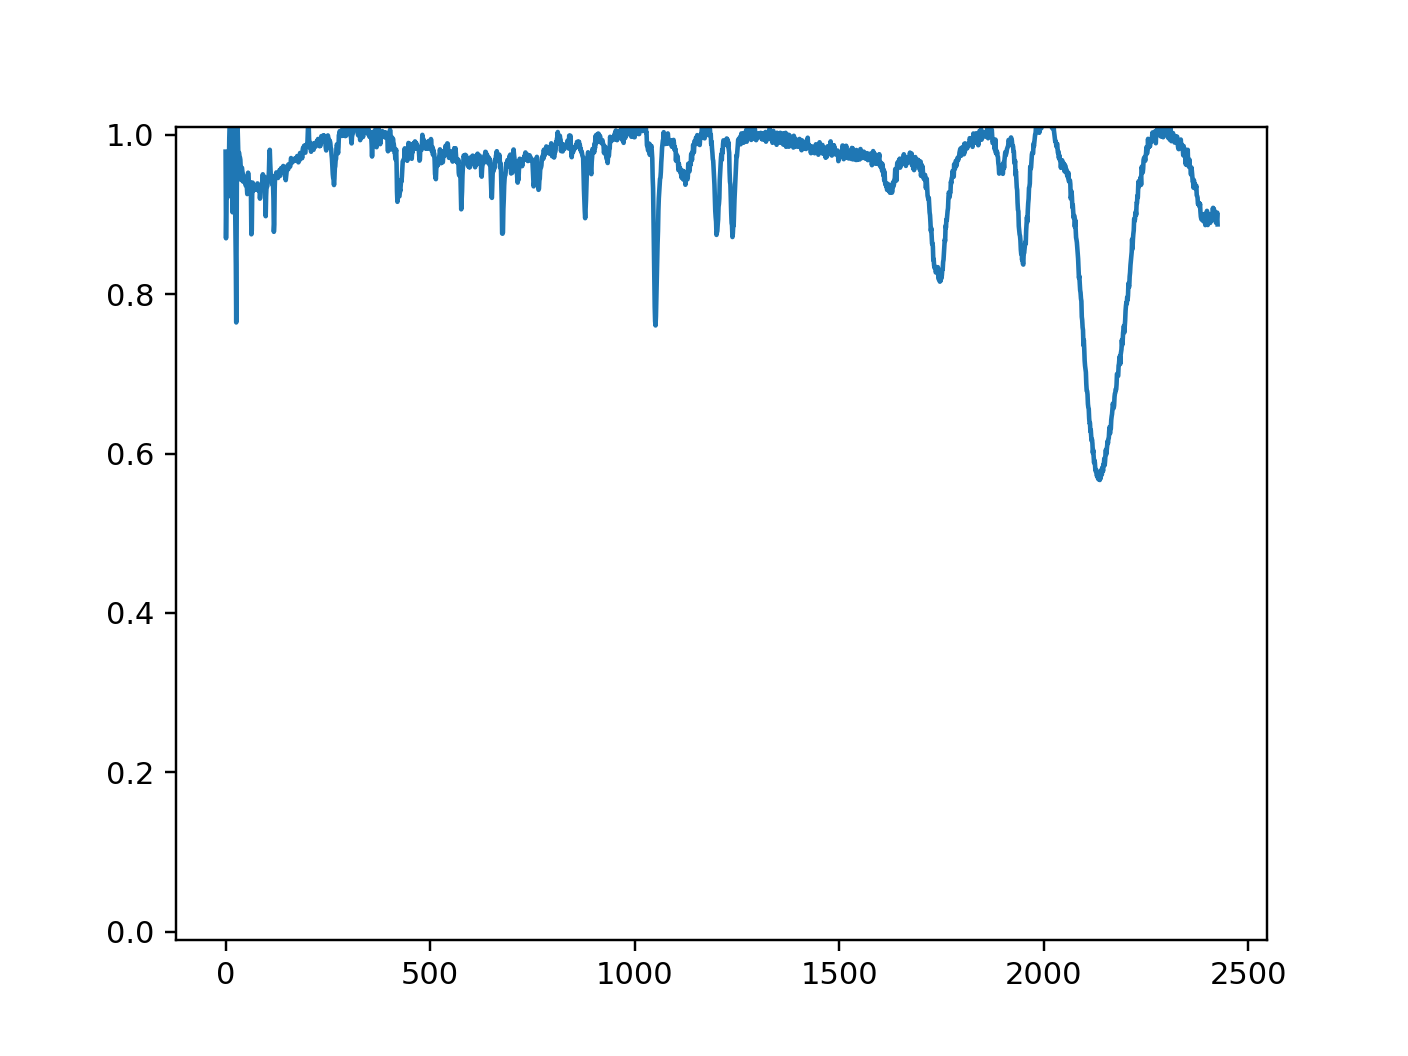

(-0.01, 1.01)

In [15]:
fig2, ax2 = plt.subplots()
ax2.plot(arr_ag/bkg_ag)
ax2.set_ylim(top=1.01, bottom=-0.01)

+----------------- Calibration -----------------+
Params before:
Name                     Value      Min      Max   Stderr     Vary     Expr Brute_Step
offset_us             -1.211e+04     -inf      inf     None     True     None     None
source_to_detector_m     16.12     -inf      inf     None     True     None     None

Params after:
Name                     Value      Min      Max   Stderr     Vary     Expr Brute_Step
offset_us             -1.211e+04     -inf      inf  0.02492     True     None     None
source_to_detector_m     15.68     -inf      inf 0.003356     True     None     None
Calibration chi^2 : 1048.9439412099769



<IPython.core.display.Javascript object>


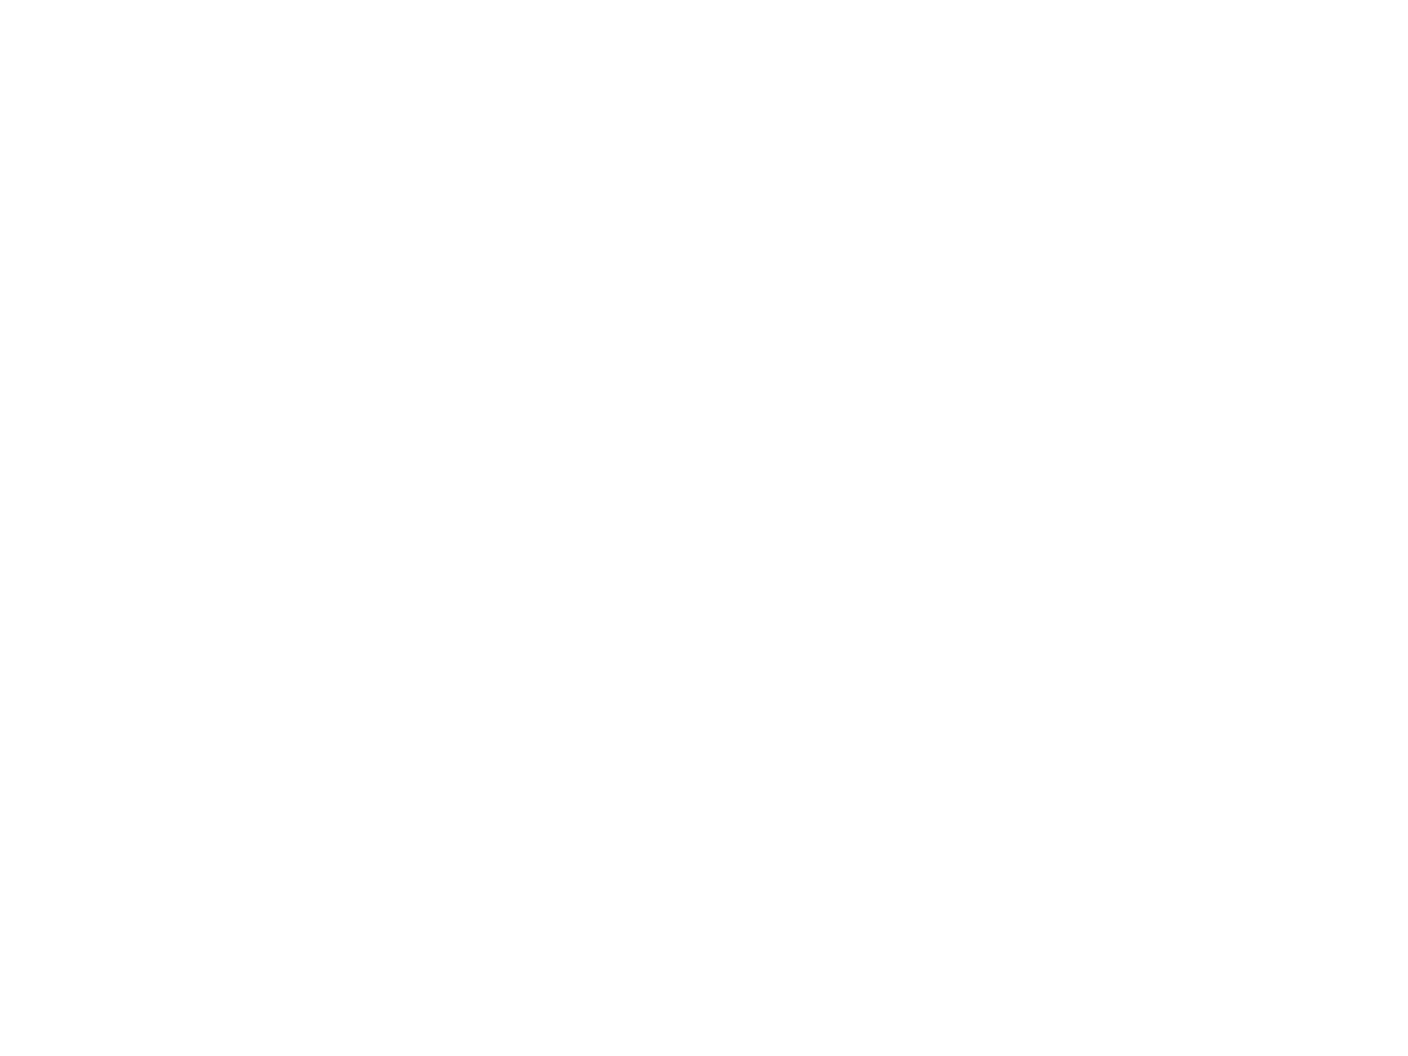

+----------------- Fitting (thickness) -----------------+
Params before:
Name                Value      Min      Max   Stderr     Vary     Expr Brute_Step
density_gcm3_Ag      10.5        0      inf     None    False     None     None
thickness_mm_Ag      0.05        0      inf     None     True     None     None

Params after:
Name                Value      Min      Max   Stderr     Vary     Expr Brute_Step
density_gcm3_Ag      10.5        0      inf        0    False     None     None
thickness_mm_Ag     0.119        0      inf 0.002931     True     None     None
Fitting chi^2 : 1029.7154136003012

Molar-conc. (mol/cm3)	Before_fit	After_fit
Ag	0.09734101431191028	0.09734101431191028




<IPython.core.display.Javascript object>


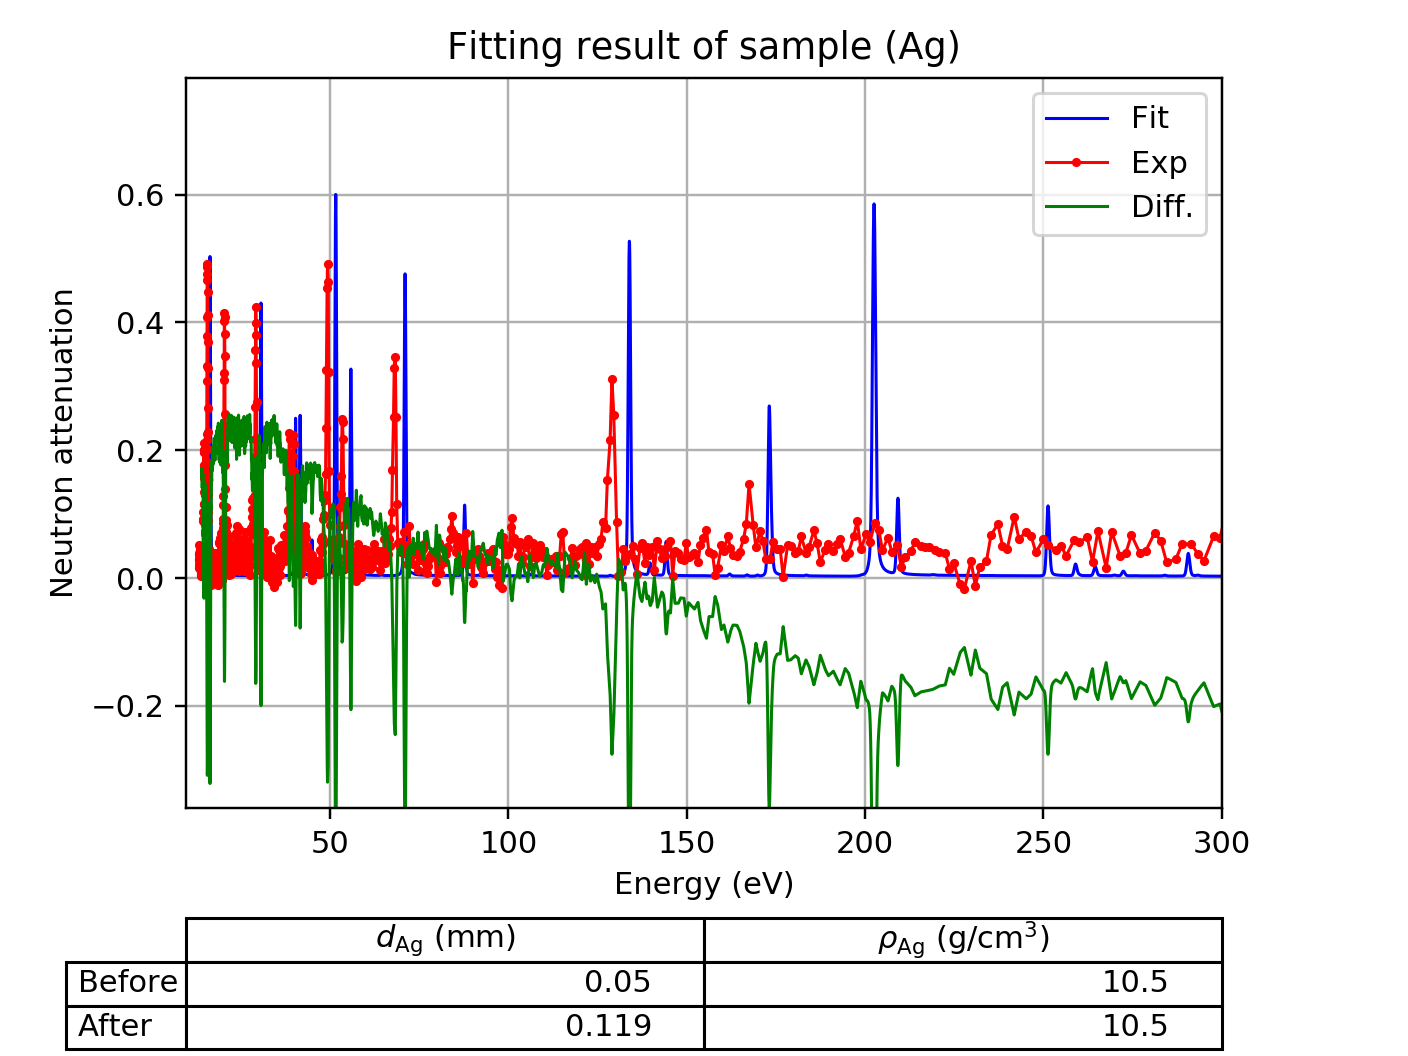

In [7]:
# Calibrate the peak positions
calibration = Calibration(data_file=data_file,
                          spectra_file=spectra_file,
                          layer=layer,
                          energy_min=energy_min,
                          energy_max=energy_max,
                          energy_step=energy_step,
                          repeat=repeat,
                          folder=folder,
                          baseline=baseline)

calibration.norm_to(norm_to_file)
calibration.slice(slice_start=image_start, slice_end=image_end)

calibrate_result = calibration.calibrate(source_to_detector_m=source_to_detector_m,
                                         offset_us=offset_us,
                                         vary='all',
                                         each_step=each_step)
calibration.plot(before=before)


# Fit the peak height
fit = FitResonance(folder=folder,
                   spectra_file=spectra_file,
                   data_file=data_file,
                   repeat=repeat,
                   energy_min=energy_min,
                   energy_max=energy_max,
                   energy_step=energy_step,
                   calibrated_offset_us=calibration.calibrated_offset_us,
                   calibrated_source_to_detector_m=calibration.calibrated_source_to_detector_m,
                   norm_to_file=norm_to_file,
                   slice_start=image_start,
                   slice_end=image_end,
                   baseline=baseline)
fit_result = fit.fit(layer, vary='thickness', each_step=each_step)
fit.molar_conc()
fit.plot()